In [36]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import statistics
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from yellowbrick.model_selection import FeatureImportances
import matplotlib.gridspec as gridspec
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, matthews_corrcoef, log_loss,
                             mean_squared_error, auc)

In [4]:
%matplotlib inline

In [6]:
df = pd.read_csv('Spotify.csv')
df['mood'] = df['happy'].apply(lambda x: (x and 'happy') or 'sad')

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,track_names,artist_names,happy,genre,mood
0,0.813,0.640,2,-5.908,1,0.2720,0.2690,0.0000,0.1310,0.488,92.989,147076,4,Jolie nana,['Aya Nakamura'],1,Alternative,happy
1,0.729,0.788,10,-4.832,0,0.0908,0.0703,0.0000,0.1150,0.857,118.039,159536,4,Say My Name,"['Dimitri Vegas & Like Mike', 'Regard', 'Dimit...",1,house,happy
2,0.624,0.628,4,-6.582,0,0.0408,0.0112,0.0191,0.0814,0.772,114.556,147071,4,Let Me Move You - From the Netflix film Work It,['Sabrina Carpenter'],1,pop,happy
3,0.660,0.755,0,-4.501,0,0.0469,0.0876,0.0000,0.1020,0.862,145.948,156368,4,NIGHTRIDER,['Arizona Zervas'],1,pop,happy
4,0.789,0.711,2,-4.248,1,0.0410,0.0332,0.0000,0.0876,0.753,112.985,190306,4,Take You Dancing,['Jason Derulo'],1,pop,happy


In [23]:
X = df.loc[:,['danceability', 'energy', 'key', 
                      'loudness', 'mode', 'speechiness', 
                      'acousticness', 'instrumentalness', 'liveness', 
                      'valence','tempo']]

y = df['happy']

In [43]:
def model_pipeline(X,y):
    '''
   Function to streamline model selection
    
    '''
    # 80:20 split holding out test set. Calling kfold because i have a small sample size
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify = y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=43, stratify = y)
    kf = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)

    classifiers = [KNeighborsClassifier(),LogisticRegression(),RandomForestClassifier()]
    class_label = ['k-Nearest Neighbor','Logistic Regression','Random Forest']
    columns = ['Classifier','ROC AUC','Accuracy','Precision','Recall','F1-Score']

    clf_df = pd.DataFrame(index=[0],columns=columns)
    fig = plt.figure(figsize=(12,4))

    for clf in classifiers:
    
        # FIT CLASSIFIER
        clf.fit(X_train,y_train)

        # PREDICT ON TEST SET
        y_pred = clf.predict(X_test)

        # ACCURACY SCORE
        acc = accuracy_score(y_test, y_pred)
        
        # F1 SCORE
        f1 = f1_score(y_test, y_pred)

        # PROBABILITIES
        y_pred_prob = clf.predict_proba(X_test)[:,1]

        # ROC SCORES 
        fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob)
        rocauc = roc_auc_score(y_test,y_pred_prob)

        # ROC CURVES
        ax1= plt.subplot(121)
        plt.plot([0,1], [0,1], color='navy', lw=1)
        plt.plot(fpr, tpr, lw=1, label=class_label[classifiers.index(clf)])
        plt.xlim([-.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curves')
        plt.legend(loc='best',fontsize=12)

        # PRECISION & RECALL 
        prscore = precision_score(y_test,clf.predict(X_test))
        recscore = recall_score(y_test,clf.predict(X_test))

        # ADD SCORES TO DF
        clf_df.loc[classifiers.index(clf)] = [class_label[classifiers.index(clf)],
                                              '{:.2%}'.format(rocauc),
                                              '{:.2%}'.format(acc),'{:.2%}'.format(prscore),
                                              '{:.2%}'.format(recscore),'{:.2%}'.format(f1)]

    plt.tight_layout()
    clf_df = clf_df.set_index('Classifier')
    print(clf_df)
    plt.show()


/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/isaacnwang/opt/anaconda3/lib/py

                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   64.18%   60.95%    61.04%  61.52%   61.28%
Logistic Regression  80.11%   73.17%    72.24%  75.67%   73.91%
Random Forest        82.63%   76.11%    75.48%  77.65%   76.55%


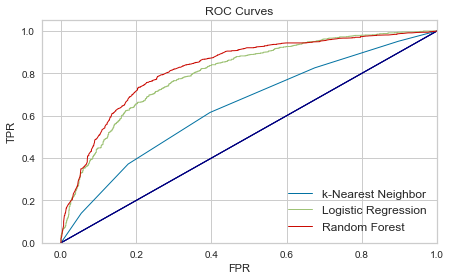

In [44]:
model_pipeline(X,y)

In [53]:
v_X = df.loc[:,['valence']]

a_X = df.loc[:,['acousticness']]

e_X = df.loc[:,['energy']]

va_X = df.loc[:,['valence','acousticness']]

ae_X = df.loc[:,['acousticness','energy']]

ve_X = df.loc[:,['valence','energy']]

ae_X = df.loc[:,['acousticness','energy']]

vae_X = df.loc[:,['energy', 'acousticness', 'valence']]

/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   67.04%   63.34%    62.84%  66.07%   64.42%
Logistic Regression  73.57%   68.01%    67.83%  69.04%   68.43%
Random Forest        66.44%   62.39%    62.10%  64.49%   63.27%


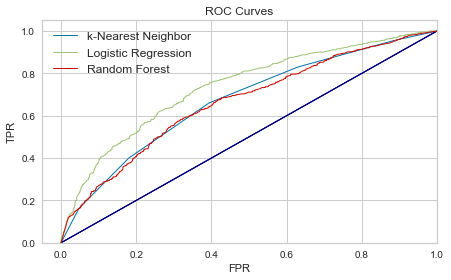

In [50]:
model_pipeline(v_X,y)

/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   65.19%   61.75%    61.71%  62.81%   62.25%
Logistic Regression  70.06%   63.93%    62.45%  70.72%   66.33%
Random Forest        63.87%   60.51%    61.07%  58.95%   59.99%


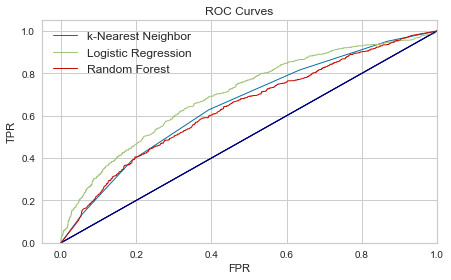

In [51]:
model_pipeline(a_X,y)

/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   66.76%   62.99%    62.79%  64.59%   63.68%
Logistic Regression  73.14%   66.52%    65.19%  71.51%   68.21%
Random Forest        67.39%   62.10%    62.13%  62.81%   62.47%


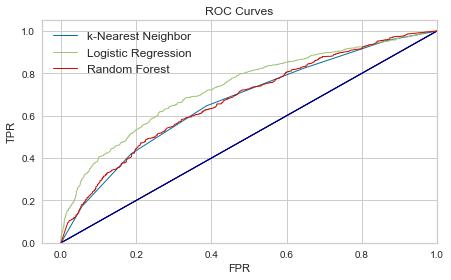

In [52]:
model_pipeline(e_X,y)

/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   74.06%   67.86%    67.67%  68.94%   68.30%
Logistic Regression  76.76%   69.20%    68.25%  72.30%   70.22%
Random Forest        73.85%   67.56%    67.18%  69.24%   68.19%


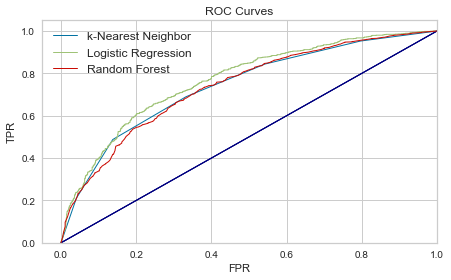

In [54]:
model_pipeline(va_X,y)

/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   73.78%   68.36%    67.84%  70.33%   69.06%
Logistic Regression  77.50%   70.99%    69.50%  75.27%   72.27%
Random Forest        73.76%   67.16%    66.70%  69.14%   67.90%


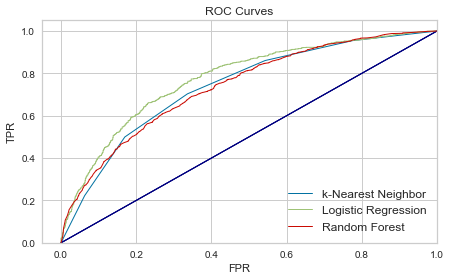

In [55]:
model_pipeline(ve_X,y)

/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   68.43%   63.44%    64.04%  62.02%   63.02%
Logistic Regression  73.83%   66.77%    65.05%  73.10%   68.84%
Random Forest        69.28%   62.99%    63.66%  61.33%   62.47%


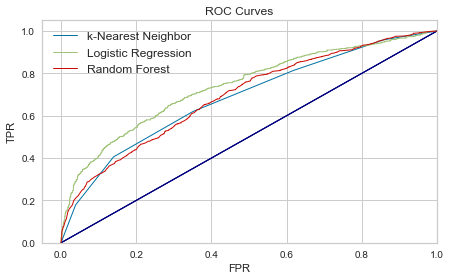

In [56]:
model_pipeline(ae_X,y)

/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/isaacnwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


                    ROC AUC Accuracy Precision  Recall F1-Score
Classifier                                                     
k-Nearest Neighbor   75.16%   70.09%    70.59%  69.34%   69.96%
Logistic Regression  77.80%   70.84%    69.41%  74.98%   72.09%
Random Forest        77.63%   70.39%    70.13%  71.51%   70.81%


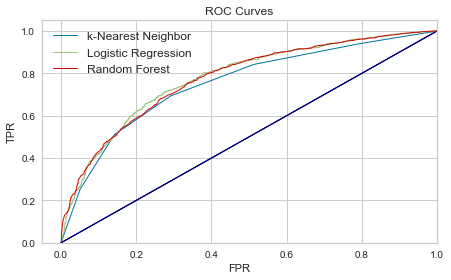

In [57]:
model_pipeline(vae_X,y)